Examples from the book "A collection of Data Science Takehome Challenges" <br> 
Ref from <br> 
1. [stasi009/TakeHomeDataChallenges](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/20.AdsAnalysis/analyze_ads.py)<br>
2. [JifuZhao/DS-Take-Home](https://github.com/JifuZhao/DS-Take-Home) <br>
3. [ishaojunzhang/ads](https://github.com/ishaojunzhang/ads/blob/master/ads_analysis.ipynb)

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.linalg as slin
from sklearn.linear_model import LinearRegression

In [2]:
ads = pd.read_csv("../Documents/Data/ad_table.csv")
ads['date'] = pd.to_datetime(ads.date)
ads.rename(columns={"avg_cost_per_click":"cost",'total_revenue':'revenue'},inplace=True)

In [3]:
print (ads.shape)
ads.head()

(2115, 7)


,date,shown,clicked,converted,cost,revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


- [Subtract two datetime to get the number of days (python)
](https://stackoverflow.com/questions/43460584/subtract-two-datetime-to-get-the-number-of-days-python/43460688)

- [Mastering Dates and Timestamps in Pandas (and Python in general)](https://towardsdatascience.com/mastering-dates-and-timestamps-in-pandas-and-python-in-general-5b8c6edcc50c)

In [10]:
################################
X = ads.loc[:,['ad','date','shown']]
firstday = X.date.min()
X['days'] = X.date.map(lambda dt: (dt - firstday).days)
X['weekday'] = X.date.map(lambda dt: dt.day_name())

In [38]:
print (firstday, type(firstday))
X.date.head(1)

2015-10-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


0   2015-10-01
Name: date, dtype: datetime64[ns]

In [11]:
X.head()

,ad,date,shown,days,weekday
0,ad_group_1,2015-10-01,65877,0,Thursday
1,ad_group_1,2015-10-02,65100,1,Friday
2,ad_group_1,2015-10-03,70658,2,Saturday
3,ad_group_1,2015-10-04,69809,3,Sunday
4,ad_group_1,2015-10-05,68186,4,Monday


In [19]:
pd.get_dummies(X, columns=['weekday'], prefix='').head(1)

,ad,date,shown,days,_Friday,_Monday,_Saturday,_Sunday,_Thursday,_Tuesday,_Wednesday
0,ad_group_1,2015-10-01,65877,0,0,0,0,0,1,0,0


In [21]:
pd.get_dummies(X,columns=['weekday'],prefix_sep='').head(1)

,ad,date,shown,days,weekdayFriday,weekdayMonday,weekdaySaturday,weekdaySunday,weekdayThursday,weekdayTuesday,weekdayWednesday
0,ad_group_1,2015-10-01,65877,0,0,0,0,0,1,0,0


In [22]:
X = pd.get_dummies(X,columns=['weekday'],prefix='',prefix_sep='')
del X['Sunday']
X.head()

,ad,date,shown,days,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
0,ad_group_1,2015-10-01,65877,0,0,0,0,1,0,0
1,ad_group_1,2015-10-02,65100,1,1,0,0,0,0,0
2,ad_group_1,2015-10-03,70658,2,0,0,1,0,0,0
3,ad_group_1,2015-10-04,69809,3,0,0,0,0,0,0
4,ad_group_1,2015-10-05,68186,4,0,1,0,0,0,0


In [23]:
#######################
time_features = [u'days', u'Friday', u'Monday', u'Saturday',u'Thursday', u'Tuesday', u'Wednesday']

def fit_linear_regression(df):
    features = df.loc[:,time_features]
    target = df['shown']

    lr = LinearRegression()
    lr.fit(features,target)

    return lr

lrmodels = X.groupby(by='ad').apply(fit_linear_regression)

In [28]:
print (len(lrmodels))
lrmodels[:5]

40


ad
ad_group_1     LinearRegression()
ad_group_10    LinearRegression()
ad_group_11    LinearRegression()
ad_group_12    LinearRegression()
ad_group_13    LinearRegression()
dtype: object

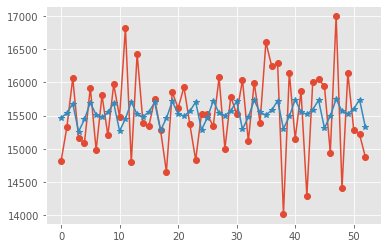

In [33]:
##########################
adname = 'ad_group_15'
data = X.loc[X.ad == adname,time_features]
ytrue = X.loc[X.ad == adname,'shown']

model = lrmodels.loc[adname]
ypred = model.predict(data)

plt.plot(data.days,ytrue,marker='o')
plt.plot(data.days,ypred,marker='*')

In [39]:
ads.head()

,date,shown,clicked,converted,cost,revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [40]:
###############################
ads['net_revenue'] = ads.apply(lambda s: s['revenue'] - s['cost'] * s['clicked'],axis=1)

def avg_net_revenue_per_show(df):
    total_net_revenue = df.net_revenue.sum()
    total_shown = df.shown.sum()
    return total_net_revenue / total_shown

net_revenue_per_show_grps = ads.groupby("ad").apply(avg_net_revenue_per_show).sort_values(ascending=False)

In [44]:
print (len(net_revenue_per_show_grps))
net_revenue_per_show_grps[:5]

40


ad
ad_group_16    0.020516
ad_group_2     0.020116
ad_group_14    0.016485
ad_group_31    0.005824
ad_group_27    0.000725
dtype: float64

In [61]:
###################
def __statistics(values,suffix,d):
    d['mean_{}'.format(suffix)] = values.mean()

    qs = [25, 50, 75]
    percentiles = np.percentile(values, qs) # [0.52155573, 0.99722222, 1.89079365]
#     for q, p in itertools.izip(qs, percentiles):
    for q, p in zip(qs, percentiles):
        d['{}p_{}'.format(q,suffix)] = p 

def statistics_changes(df):
    costs = df.sort_values(by='date')['cost'].values # array([0.9 , 2.62, 0.72, ..., 1.71, 1.87, 0.99])
    prev_cost = costs[:-1] # array([0.9 , 2.62, 0.72, ..., 1.82, 1.71, 1.87])
    curr_cost = costs[1:] # array([2.62, 0.72, 4.19, ..., 1.71, 1.87, 0.99])

    d = {}
    __statistics(curr_cost / prev_cost,'chrate',d)
    __statistics(curr_cost - prev_cost,'abschg',d)

    return pd.Series(d)

change_statistics = ads.groupby('ad').apply(statistics_changes)

<ipython-input-61-e000787b1109>:17: RuntimeWarning: divide by zero encountered in true_divide
  __statistics(curr_cost / prev_cost,'chrate',d)


In [63]:
print (change_statistics.shape)
change_statistics.head()

(40, 8)


,mean_chrate,25p_chrate,50p_chrate,75p_chrate,mean_abschg,25p_abschg,50p_abschg,75p_abschg
ad,,,,,,,,
ad_group_1,1.007436,0.930747,0.989999,1.094223,0.001538,-0.0725,-0.010,0.0850
ad_group_10,1.011576,0.920666,0.976923,1.105323,0.003137,-0.0900,-0.030,0.1100
ad_group_11,inf,0.957944,1.002941,1.052941,0.005769,-0.0725,0.005,0.0900
ad_group_12,inf,0.945670,1.005051,1.060455,-0.002692,-0.1200,0.010,0.1200
ad_group_13,inf,0.958716,1.000015,1.071825,-0.001538,-0.0725,0.000,0.1125


<AxesSubplot:>

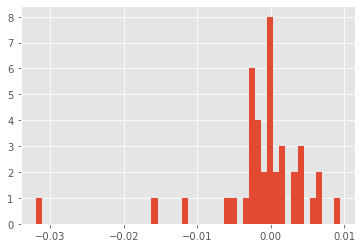

In [64]:
change_statistics['mean_abschg'].hist(bins=50)

array([[<AxesSubplot:title={'center':'25p_abschg'}>,
        <AxesSubplot:title={'center':'25p_chrate'}>,
        <AxesSubplot:title={'center':'50p_abschg'}>],
       [<AxesSubplot:title={'center':'50p_chrate'}>,
        <AxesSubplot:title={'center':'75p_abschg'}>,
        <AxesSubplot:title={'center':'75p_chrate'}>],
       [<AxesSubplot:title={'center':'mean_abschg'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

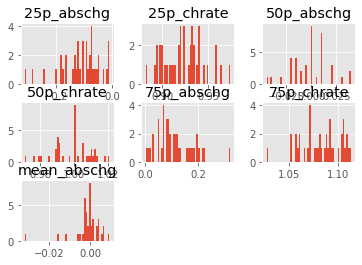

In [66]:
change_statistics.loc[:,[u'25p_abschg', u'25p_chrate', u'50p_abschg', u'50p_chrate',u'75p_abschg', \
                         u'75p_chrate', u'mean_abschg']].hist(bins=50)